In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima


In [3]:
import warnings
warnings.filterwarnings('ignore')

##  2.1指数平滑

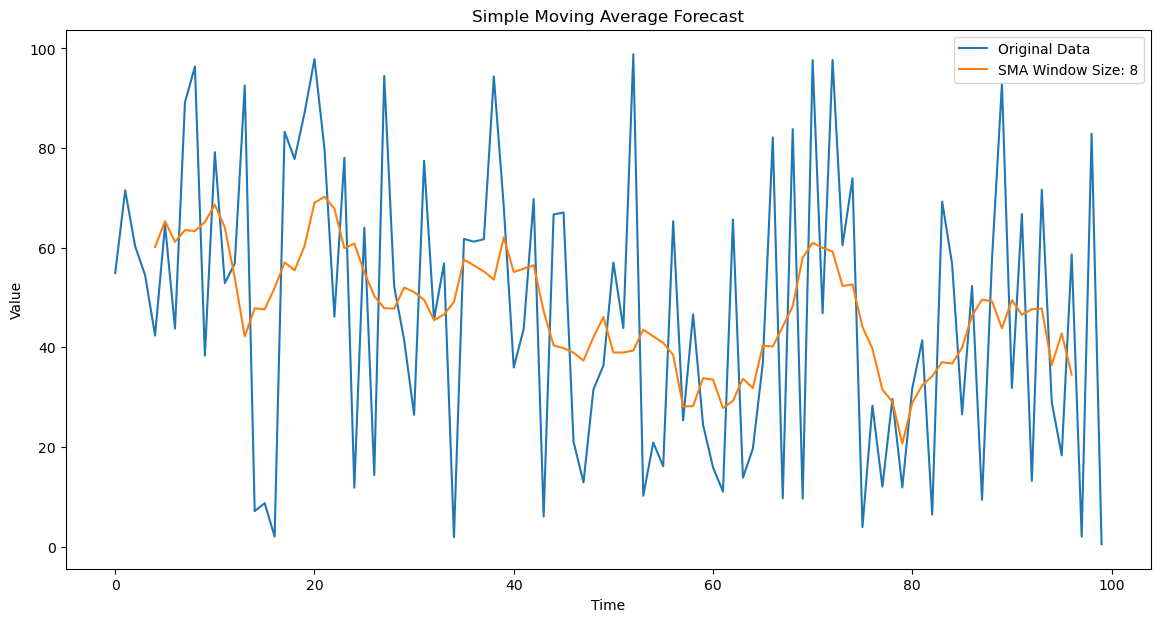

In [4]:
# 简单移动平均
# Function to calculate Simple Moving Average
def simple_moving_average(data, window_size):
    weights = np.ones(window_size) / window_size
    sma = np.convolve(data, weights, mode='valid')
    return sma

# Function to generate random data for testing
def generate_random_data(size):
    np.random.seed(0)  # Seed for reproducibility
    random_data = np.random.rand(size) * 100  # Generate random numbers between 0 and 100
    return random_data

# Function to adjust SMA window size
def adjust_sma_parameter(data, initial_window_size, adjustment):
    window_size = initial_window_size + adjustment
    if window_size < 1:
        window_size = 1
    return simple_moving_average(data, window_size)

# Test the SMA with randomly generated data
data_size = 100
test_data = generate_random_data(data_size)

# Initial SMA window size
initial_window_size = 5

# Adjust the parameter (e.g., increase or decrease the window size)
adjustment = 3
adjusted_sma = adjust_sma_parameter(test_data, initial_window_size, adjustment)

# Plot original data and SMA
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Original Data')
plt.plot(np.arange(initial_window_size - 1, data_size - 3), adjusted_sma, label=f'SMA Window Size: {initial_window_size + adjustment}')
plt.legend()
plt.title('Simple Moving Average Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

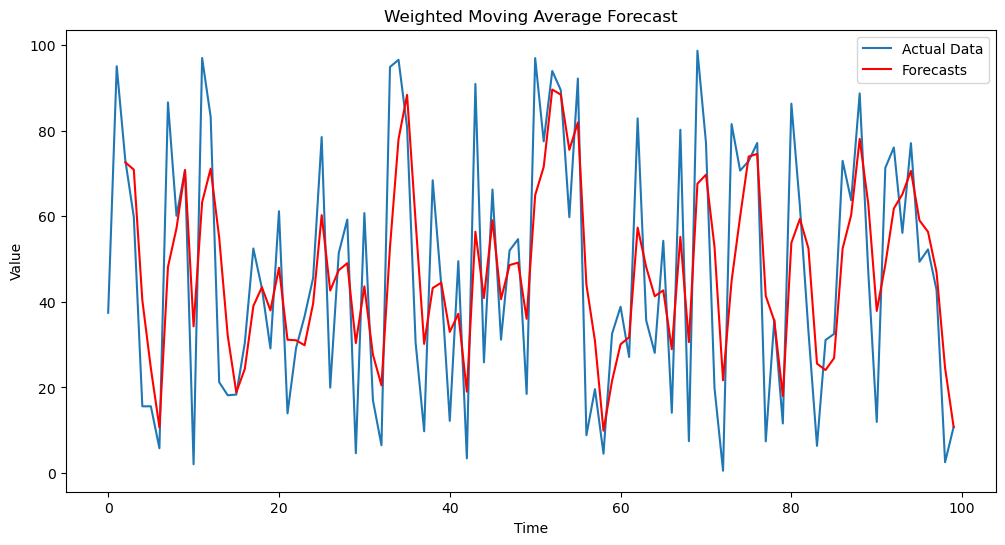

Final adjusted weights: [0.5 0.3 0.2]


In [5]:
# 加权移动平均
# Generate random data for testing
np.random.seed(42)  # Set seed for reproducibility
data_length = 100
data = np.random.rand(data_length) * 100  # Random data between 0 and 100

# Function to calculate weighted moving average
def weighted_moving_average(data, weights):
    return np.convolve(data, weights)[len(weights)-1:-len(weights)+1]

# Function to adjust weights based on error
def adjust_weights(weights, error, learning_rate=0.01):
    # Simple adjustment: reduce the weight proportionally to the error
    weights = np.array(weights) * (1 - learning_rate * error)
    # Normalize weights so they sum to 1
    weights /= np.sum(weights)
    return weights

# Initial weights for 3-period WMA
weights = np.array([0.5, 0.3, 0.2])

# Forecast using WMA and adjust weights
forecasts = []
adjusted_weights = weights.copy()
for i in range(len(data) - len(weights)):
    window = data[i:i+len(weights)]
    forecast = weighted_moving_average(window, adjusted_weights)
    forecasts.append(forecast[0])
    # Calculate error (difference between forecast and actual value)
    error = data[i+len(weights)] - forecast
    # Adjust weights based on error
    adjusted_weights = adjust_weights(adjusted_weights, error)

# Append the last known value to the forecasts for plotting
forecasts.append(data[-1])

# Plot the original data and the forecasts
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Data')
plt.plot(range(len(weights)-1, len(data)), forecasts, label='Forecasts', color='red')
plt.title('Weighted Moving Average Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

print("Final adjusted weights:", adjusted_weights)

Initial Mean Squared Error: 652.9818837079628
Optimized alpha: 0.99
Optimized Mean Squared Error: 0.16596205390710522


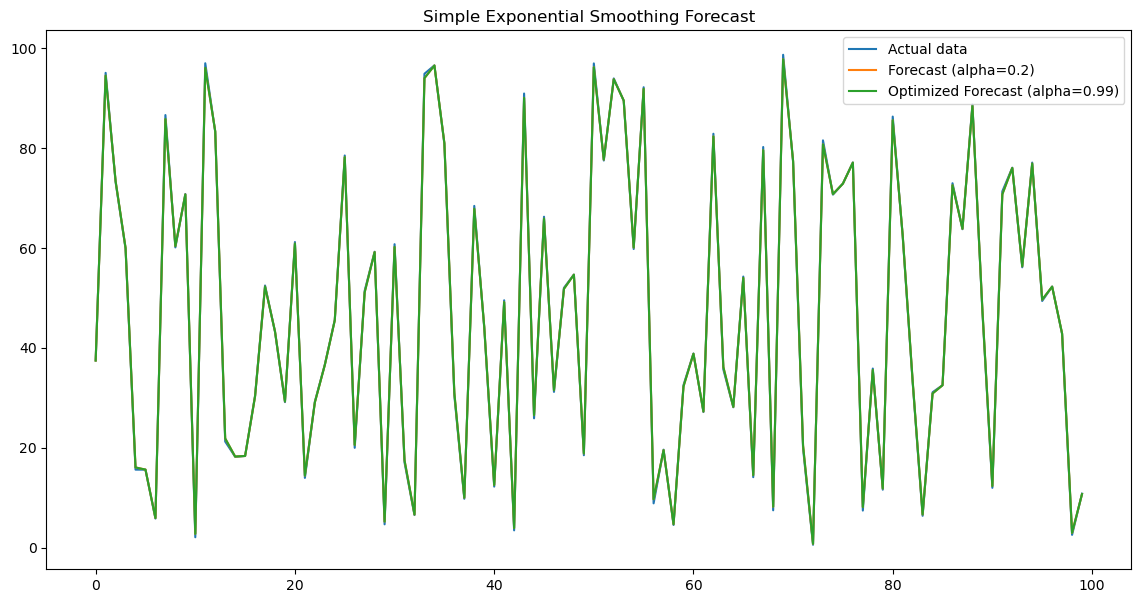

In [6]:
# 简单指数平滑
# Function to apply Simple Exponential Smoothing
def simple_exponential_smoothing(data, alpha):
    result = [data[0]]  # First value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
    return result

# Function to generate random test data
def generate_test_data(size, seed=42):
    np.random.seed(seed)
    data = np.random.rand(size) * 100  # Generate random data between 0 and 100
    return data

# Function to calculate Mean Squared Error
def mean_squared_error(actual, forecast):
    mse = np.mean((np.array(actual) - np.array(forecast)) ** 2)
    return mse

# Generate test data
size = 100  # Number of data points
test_data = generate_test_data(size)

# Set initial alpha value
alpha = 0.2

# Apply Simple Exponential Smoothing
forecast = simple_exponential_smoothing(test_data, alpha)

# Calculate Mean Squared Error
mse = mean_squared_error(test_data[1:], forecast[1:])
print(f"Initial Mean Squared Error: {mse}")

# Adjust alpha to minimize the Mean Squared Error
best_alpha = alpha
best_mse = mse
for a in np.linspace(0.01, 0.99, 100):
    forecast = simple_exponential_smoothing(test_data, a)
    mse = mean_squared_error(test_data[1:], forecast[1:])
    if mse < best_mse:
        best_mse = mse
        best_alpha = a

print(f"Optimized alpha: {best_alpha}")
print(f"Optimized Mean Squared Error: {best_mse}")

# Forecast with optimized alpha
optimized_forecast = simple_exponential_smoothing(test_data, best_alpha)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_data, label='Actual data')
plt.plot(forecast, label=f'Forecast (alpha={alpha})')
plt.plot(optimized_forecast, label=f'Optimized Forecast (alpha={best_alpha})')
plt.title('Simple Exponential Smoothing Forecast')
plt.legend()
plt.show()

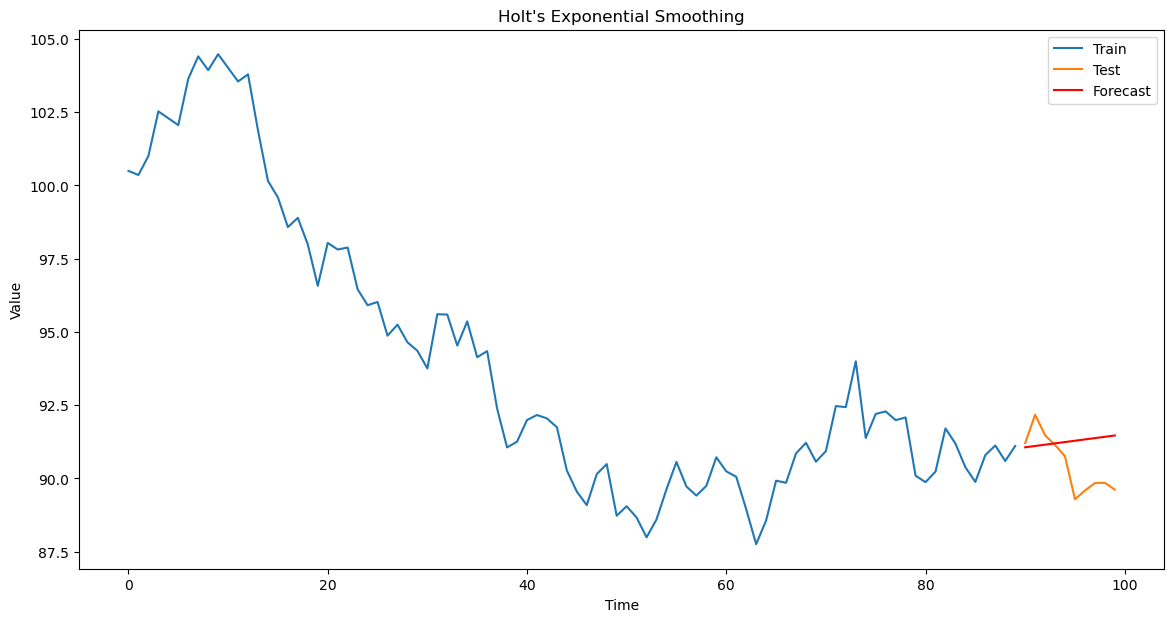

Mean Absolute Percentage Error (MAPE): 1.20%


In [7]:
# Holt winter
# Generate random data for testing
np.random.seed(42)  # For reproducibility
data_points = 100
time_series = np.cumsum(np.random.randn(data_points)) + 100  # Random walk data

# Convert to pandas Series for convenience
data_series = pd.Series(time_series)

# Split data into train and test
train, test = data_series[:-10], data_series[-10:]

# Initialize parameters
alpha = 0.8  # Level smoothing coefficient
beta = 0.2   # Trend smoothing coefficient

# Fit Holt's Exponential Smoothing model
model = ExponentialSmoothing(train, trend='add', initialization_method='estimated')
model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta)

# Forecast the next 10 points
forecast = model_fit.forecast(steps=10)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Holt\'s Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculate error metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, forecast)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Optimized alpha: 0.0
Optimized beta: 2.928352450576405e-07
Optimized gamma: 0.0
Forecasted values: [13.11076375 12.90311909 12.77721007 13.79722494 13.49573544 14.18152422
 13.76972696 13.79521483 13.44414575 13.39804021 14.33060769 14.003479  ]


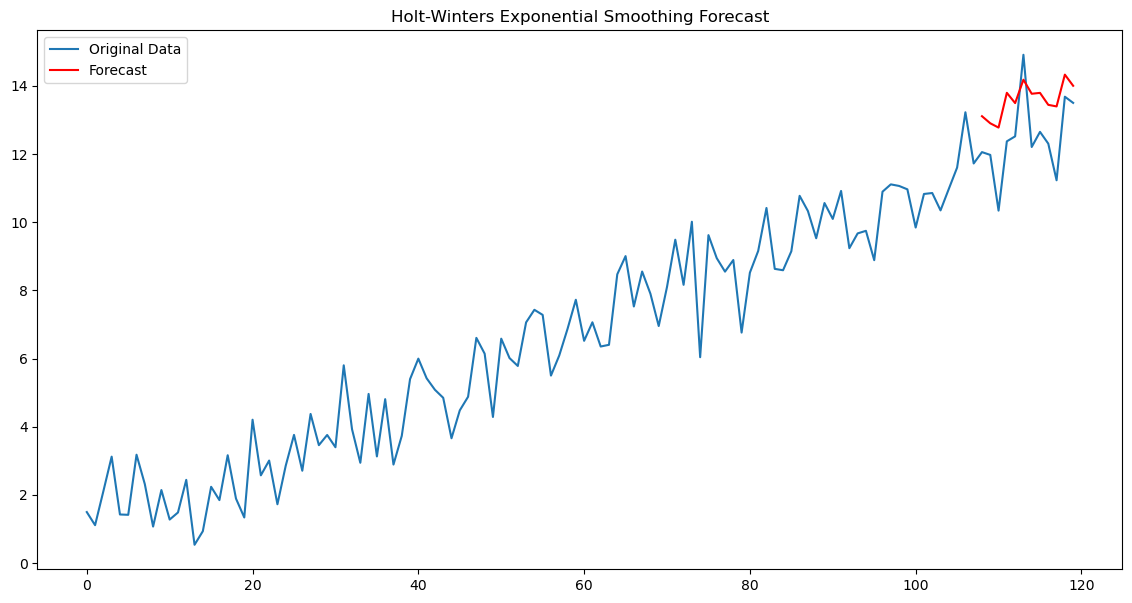

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate random seasonal data
n_periods = 120
seasonal_periods = 12
trend_factor = 0.1
seasonality_factor = np.array([1.0 + 0.3 * np.sin((2 * np.pi * (i % seasonal_periods)) / seasonal_periods) for i in range(n_periods)])
noise = np.random.normal(loc=0.0, scale=1.0, size=n_periods)
data = trend_factor * np.arange(n_periods) + seasonality_factor + noise

# Convert to pandas Series for convenience
time_series = pd.Series(data)

# Define objective function to minimize (one-step forecast error)
def objective_function(params, series, seasonal_periods):
    alpha, beta, gamma = params
    # Fit model with given params
    model = ExponentialSmoothing(series, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    # Calculate sum of squared errors
    error = fit.sse
    return error

# Initial guesses for optimization
initial_guess = [0.1, 0.1, 0.1]

# Set bounds for alpha, beta, and gamma
bounds = [(0, 1), (0, 1), (0, 1)]

# Perform optimization
optimal_result = minimize(
    objective_function,
    initial_guess,
    args=(time_series, seasonal_periods),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal alpha, beta, gamma
alpha_opt, beta_opt, gamma_opt = optimal_result.x

# Fit model using optimized parameters
hw_model = ExponentialSmoothing(time_series, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
hw_fit = hw_model.fit(smoothing_level=alpha_opt, smoothing_slope=beta_opt, smoothing_seasonal=gamma_opt)

# Forecast the next 12 periods
forecast = hw_fit.forecast(12)

# Print the optimized parameters and forecast
print('Optimized alpha:', alpha_opt)
print('Optimized beta:', beta_opt)
print('Optimized gamma:', gamma_opt)
print('Forecasted values:', forecast.values)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(time_series, label='Original Data')
plt.plot(time_series.index[-12:], forecast.values, label='Forecast', color='red')
plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.legend()
plt.show()

## 2.4 arima自动调参

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -276.897
Date:                Thu, 18 Jan 2024   AIC                            561.795
Time:                        16:44:03   BIC                            574.988
Sample:                             0   HQIC                           567.134
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0395      0.034     -1.164      0.244      -0.106       0.027
ar.L1         -0.4866      0.094     -5.151      0.000      -0.672      -0.301
ma.L1         -0.2729      0.114     -2.394      0.0

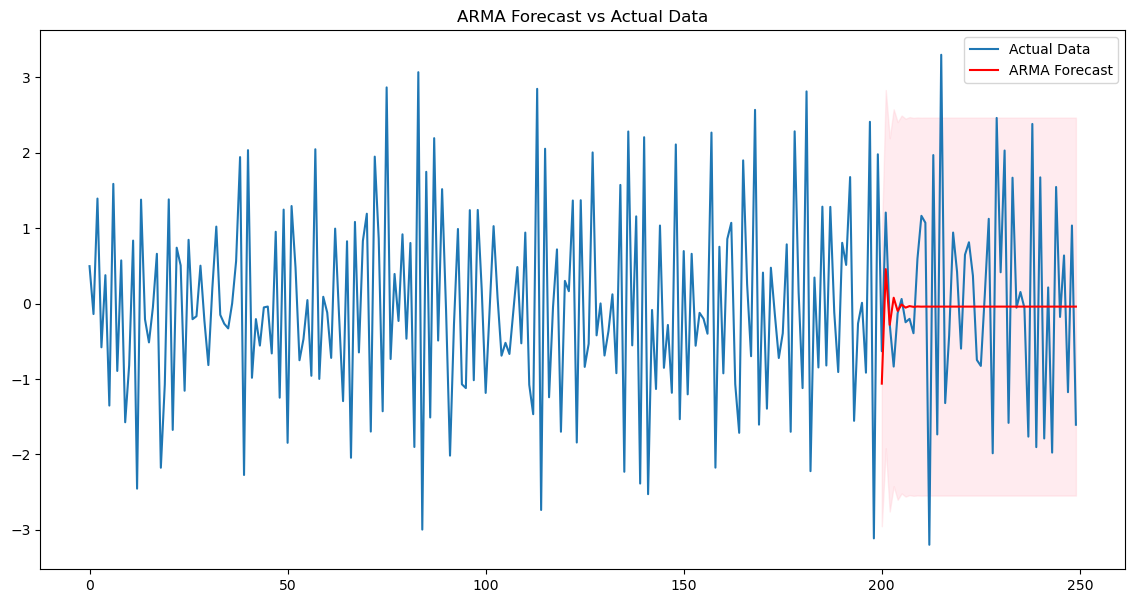

In [9]:
# ARMA
# Set the random seed for reproducibility
np.random.seed(42)

# Generate random data for ARMA process
n_samples = 250
# Assume an AR(1) process with a coefficient of 0.7 and MA(1) with a coefficient of -0.3
ar_coefficient = 0.7
ma_coefficient = -0.3
ar = np.array([1, -ar_coefficient])  # AR parameter
ma = np.array([1, ma_coefficient])   # MA parameter

# Generate ARMA process data using numpy's random function
arma_process = np.random.normal(size=n_samples)
for i in range(2, n_samples):
    arma_process[i] = ar[1] * arma_process[i - 1] + ma[1] * np.random.normal() + np.random.normal()

# Convert to pandas series
time_series_data = pd.Series(arma_process)

# Split the data into training and testing sets
train_size = int(0.8 * n_samples)
train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Create an ARMA model with the training data
# The order (p, d, q) of the model corresponds to AR(p), I(d), and MA(q)
# Since we know the process, we use p=1 and q=1, with d=0 (no differencing)
arma_model = ARIMA(train_data, order=(1, 0, 1))
arma_result = arma_model.fit()

# Summary of the model
print(arma_result.summary())

# Forecast the next steps ahead using the model
forecast_steps = n_samples - train_size
forecast = arma_result.get_forecast(steps=forecast_steps)
forecast_index = np.arange(train_size, n_samples)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(time_series_data, label='Actual Data')
plt.plot(forecast_index, forecast.predicted_mean, label='ARMA Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('ARMA Forecast vs Actual Data')
plt.legend()
plt.show()

In [10]:


# ARIMA
# Generate random time series data
np.random.seed(42)
n_samples = 100
time_series = np.cumsum(np.random.randn(n_samples))  # Random walk
dates = pd.date_range(start='2020-01-01', periods=n_samples)
data = pd.Series(time_series, index=dates)

# Split the dataset into train and test sets
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# Function to evaluate ARIMA model with different parameters
def evaluate_arima_model(order):
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        return model_fit.aic
    except:
        return float('inf')

# Grid search for p, d, q parameters
def optimize_arima(parameters_list):
    best_aic = float('inf')
    best_order = None
    for param in parameters_list:
        aic = evaluate_arima_model(param)
        if aic < best_aic:
            best_aic = aic
            best_order = param
    print(f'Best ARIMA{best_order} AIC = {best_aic}')
    return best_order

# Define range of p, d, q parameters to search
p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)
parameters = [(p, d, q) for p in p_values for d in d_values for q in q_values]

# Find the best ARIMA parameters
best_order = optimize_arima(parameters)

# Fit the best ARIMA model
model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Compare forecast with actual test data
comparison_df = pd.DataFrame({'actual': test, 'forecast': forecast})
print(comparison_df)

# You can calculate performance metrics such as Mean Squared Error (MSE) here
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(comparison_df['actual'], comparison_df['forecast'])
# print(f'Mean Squared Error: {mse}')

Best ARIMA(0, 1, 0) AIC = 220.38964326563658
               actual  forecast
2020-03-21 -10.126884 -9.907212
2020-03-22  -9.769771 -9.907212
2020-03-23  -8.291877 -9.907212
2020-03-24  -8.810148 -9.907212
2020-03-25  -9.618641 -9.907212
2020-03-26 -10.120398 -9.907212
2020-03-27  -9.204996 -9.907212
2020-03-28  -8.876245 -9.907212
2020-03-29  -9.406005 -9.907212
2020-03-30  -8.892738 -9.907212
2020-03-31  -8.795660 -9.907212
2020-04-01  -7.827015 -9.907212
2020-04-02  -8.529068 -9.907212
2020-04-03  -8.856731 -9.907212
2020-04-04  -9.248839 -9.907212
2020-04-05 -10.712354 -9.907212
2020-04-06 -10.416233 -9.907212
2020-04-07 -10.155178 -9.907212
2020-04-08 -10.150065 -9.907212
2020-04-09 -10.384652 -9.907212


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=220.901, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=222.834, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=222.833, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220.390, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=224.830, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.090 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -109.195
Date:                Thu, 18 Jan 2024   AIC                            220.390
Time:                        16:44:05   BIC                            222.759
Sample:                             0   HQIC                           221.339
                    

 This problem is unconstrained.


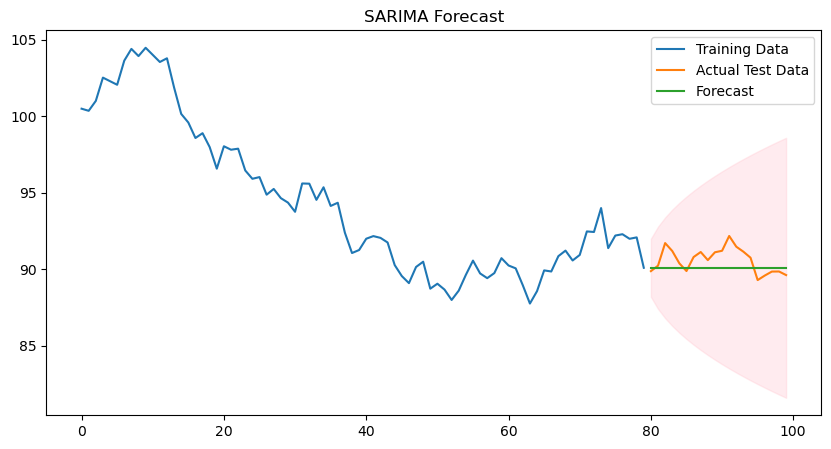

The Mean Squared Error of our forecasts is 0.854993667595274


In [11]:


# SARIMA
# Set a seed for reproducibility
np.random.seed(42)

# Generate random data for demonstration (100 data points)
data = np.random.randn(100).cumsum() + 100  # Random walk data

# Convert to pandas Series
data = pd.Series(data)

# Split data into train/test (80/20 split)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Use auto_arima to find the best SARIMA parameters
stepwise_fit = auto_arima(train, seasonal=True, trace=True,
                          error_action='ignore', suppress_warnings=True,
                          stepwise=True)

# Best model summary
print(stepwise_fit.summary())

# Fit SARIMA model with the best parameters
model = SARIMAX(train,
                order=stepwise_fit.order,
                seasonal_order=stepwise_fit.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Confidence intervals for the forecasts
confidence_intervals = forecast.conf_int()

# Plot the data and the forecast with confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# Evaluate the model
mse = ((forecast_mean - test) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {mse}')

In [13]:
from arch import arch_model
# GARCH
# Set a seed for reproducibility
np.random.seed(42)

# Simulate some data for demonstration purposes
# Let's assume the data follow a normal distribution with mean 0 and standard deviation 1
n = 1000  # number of data points
data = np.random.normal(0, 1, n)

# Convert the data to a pandas DataFrame
data = pd.Series(data)

# Define a GARCH(1,1) model
# You can adjust parameters by changing the mean, vol, and p, o, q arguments
garch_model = arch_model(data, mean='Zero', vol='GARCH', p=1, q=1)

# Fit the model to the data
results = garch_model.fit(update_freq=10)

# Print the summary of the fit
print(results.summary())

# Forecast the future volatility
forecasts = results.forecast(horizon=5, start=None, align='origin')

# Print the forecasted volatility
print(forecasts.variance[-1:])

# If you want to adjust parameters, you can do so by creating a new model
# and passing different arguments to arch_model. For example:
# garch_model_new = arch_model(data, mean='Constant', vol='GARCH', p=1, q=1)
# results_new = garch_model_new.fit(update_freq=10)
# print(results_new.summary())

Iteration:     10,   Func. Count:     54,   Neg. LLF: 1397.562582682835
Iteration:     20,   Func. Count:    110,   Neg. LLF: 1406.3608893454025
Iteration:     30,   Func. Count:    170,   Neg. LLF: 1403.6706809696248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1397.4215677942848
            Iterations: 38
            Function evaluations: 206
            Gradient evaluations: 34
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1397.42
Distribution:                  Normal   AIC:                           2800.84
Method:            Maximum Likelihood   BIC:                           2815.57
                                        No. Observations:                 1000
Date:             